## Before you start

**Configure the API key. **
1. Create a Roboflow account at https://roboflow.com/
2. Click on settings and copy private API key https://www.google.com/url?q=https%3A%2F%2Fapp.roboflow.com%2Fsettings%2Fapi
3. In Colab, go to left pane and click `Secrets` (🔑).
4. Store the Roboflow API key under the name ROBOFLOW_API_KEY

## Select Runtime

Run the nvidia-smi command to make sure you have access to GPU. If you do not have access to gpu in colab go to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sun Dec  1 01:00:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install dependencies

In [ ]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
!pip install umap-learn
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.5/880.5 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

## Load in detection model and 60 second clip of a basketball game from a google drive

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY') # load in api key
PLAYER_DETECTION_MODEL_ID = "basketball-w2xcw/1" # load in model ID
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY) # retrieve model from roboflow.com

In [ ]:
!gdown -O "010101.mp4" "https://drive.google.com/uc?id=1iG8BCCwfNwvHVzdym9jL2WH6YD9rtels" # load in video in files as 010101.mp4

Downloading...
From: https://drive.google.com/uc?id=1iG8BCCwfNwvHVzdym9jL2WH6YD9rtels
To: /content/010101.mp4
100% 10.1M/10.1M [00:00<00:00, 24.1MB/s]


In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]" # set environment variable to specify the execution provider for ONNX runtime.

## Test that video was loaded succesfully

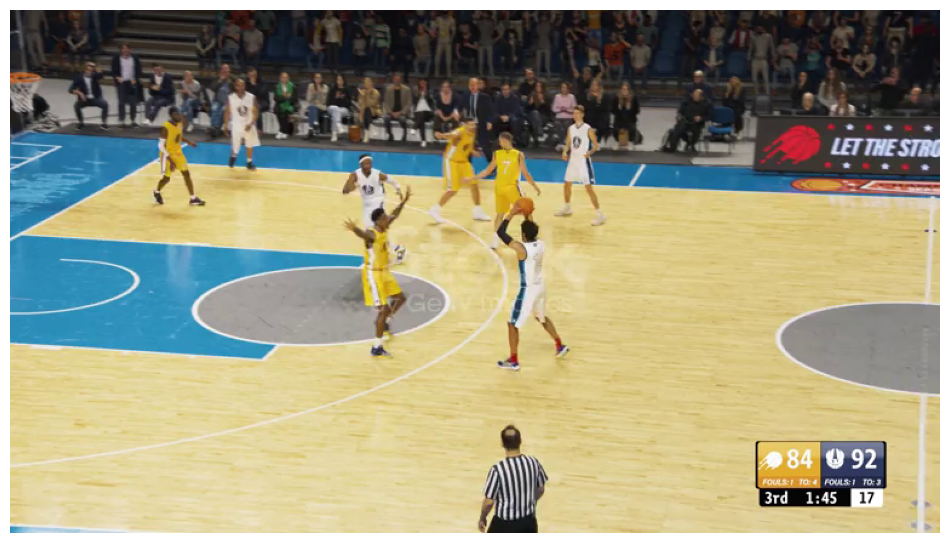

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "010101.mp4" # Path to the source video file.

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH) # Generate a frame-by-frame generator for the video.
frame = next(frame_generator) # Retrieve the first frame from the video using the generator.

sv.plot_image(frame) # Display the retrieved frame as an image.

## Create Team Classifier

In [ ]:
import supervision as sv
from tqdm import tqdm
from typing import Generator, Iterable, List, TypeVar
import numpy as np
import torch
import umap
from sklearn.cluster import KMeans
from transformers import AutoProcessor, SiglipVisionModel

V = TypeVar("V")

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224' # Pre-trained Siglip model path

def create_batches(sequence: Iterable[V], batch_size: int) -> Generator[List[V], None, None]:

    # Generate batches from a sequence with a specified batch size.
    # Args:
        # sequence (Iterable[V]): The input sequence to be batched.
        # batch_size (int): The size of each batch.
    # Yields:
        # Generator[List[V], None, None]: A generator yielding batches of the input sequence.

    batch_size = max(batch_size, 1) # Ensure batch size is at least 1
    current_batch = []
    for element in sequence:
        if len(current_batch) == batch_size: # If batch is full, yield it
            yield current_batch
            current_batch = [] # Start a new batch
        current_batch.append(element)
    if current_batch: # Yield the last batch if it's not empty
        yield current_batch


class TeamClassifier:
    def __init__(self, device: str = "cuda", batch_size: int = 32, n_clusters: int = 3):

        # Initialize the TeamClassifier for 3 clusters (Team 1, Team 2, Referees).
        # Args:
            # device (str): The device to run the model on ('cpu' or 'cuda').
            # batch_size (int): The batch size for processing crops.
            # n_clusters (int): The number of clusters (default: 3).

        self.device =  device# Set the processing device
        self.batch_size = batch_size # Set batch size for processing
        self.n_clusters = n_clusters # Number of clusters
        self.features_model = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(device) # Load the pre-trained Siglip model and processor
        self.processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)   # Initialize dimensionality reduction and clustering
        self.reducer = umap.UMAP(n_components=3, random_state=42)
        self.cluster_model = KMeans(n_clusters=n_clusters, random_state=42)

    def extract_features(self, crops: List[np.ndarray]) -> np.ndarray:

        # Extract features from image crops using the Siglip Vision Model.
        # Args:
            # crops (List[np.ndarray]): List of image crops.
        # Returns:
            # np.ndarray: Extracted feature embeddings.

        crops = [sv.cv2_to_pillow(crop) for crop in crops] # Convert OpenCV images to Pillow format
        batches = create_batches(crops, self.batch_size) # Create batches for processing
        data = []
        with torch.no_grad(): # Disable gradient computation for inference
            for batch in tqdm(batches, desc="Extracting features"):
                inputs = self.processor(images=batch, return_tensors="pt").to(self.device) # Prepare the inputs for the model
                outputs = self.features_model(**inputs) # Run inference through the Siglip model
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy() # Extract embeddings from the model's output
                data.append(embeddings)
        return np.concatenate(data) # Concatenate all embeddings into a single array

    def fit(self, crops: List[np.ndarray]) -> None:

        # Fit the UMAP and KMeans models on the extracted features.
        # Args:
            # crops (List[np.ndarray]): List of image crops.

        data = self.extract_features(crops) # Extract features from the crops
        projections = self.reducer.fit_transform(data) # Reduce dimensionality
        self.cluster_model.fit(projections) # Fit KMeans clustering

    def predict(self, crops: List[np.ndarray]) -> np.ndarray:

        # Predict the cluster assignments for new crops.
        # Args:
            # crops (List[np.ndarray]): List of image crops.
        # Returns:
            # np.ndarray: Predicted cluster labels.

        if len(crops) == 0: # Handle case with no crops
            return np.array([])
        data = self.extract_features(crops) # Extract features
        projections = self.reducer.transform(data) # Reduce dimensionality
        return self.cluster_model.predict(projections) # Predict cluster labels


# Video processing parameters
SOURCE_VIDEO_PATH = "010101.mp4"
PLAYER_ID = 2  # Class ID 2 corresponds to players
STRIDE = 30  # Process every 30th frame

# Initialize video frame generator
frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE
)

# Collect crops of players from the video
crops = []
for frame in tqdm(frame_generator, desc="Collecting player crops"):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]

    # Extract crops for players
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    crops += players_crops

print(f"Collected {len(crops)} crops.")

# Initialize and train the TeamClassifier for 3 clusters
team_classifier = TeamClassifier(device="cuda", n_clusters=3)
team_classifier.fit(crops)
print("TeamClassifier training complete.")

# Predict clusters for all crops
cluster_assignments = team_classifier.predict(crops)

# Analyze cluster distribution
from collections import Counter
cluster_counts = Counter(cluster_assignments)
labels = ["Team 1", "Referee", "Team 2"]
for cluster_id, count in cluster_counts.items():
    print(f"{labels[cluster_id]}: {count} samples")


Collected 458 crops.


Extracting features: 15it [00:07,  1.94it/s]


TeamClassifier training complete.


Extracting features: 15it [00:05,  2.62it/s]

Team 2: 173 samples
Team 1: 171 samples
Referee: 114 samples


## Visulaize Clusters

Cluster: Team 1 (Showing 5 of 171 samples)


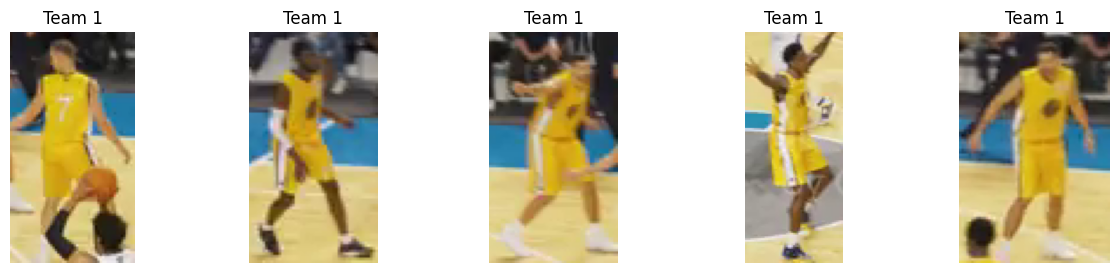

Cluster: Referee (Showing 5 of 114 samples)


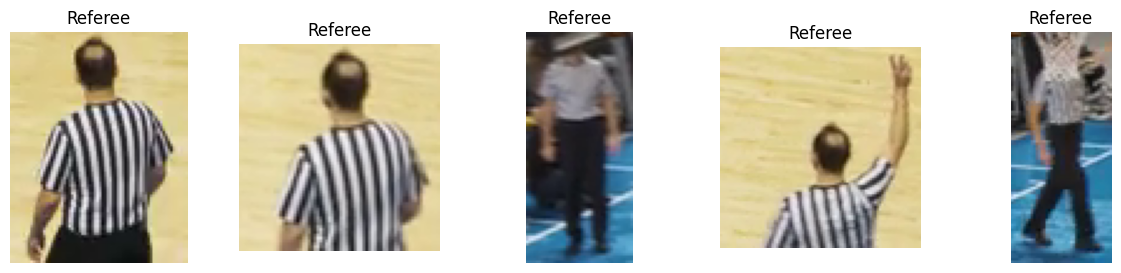

Cluster: Team 2 (Showing 5 of 173 samples)


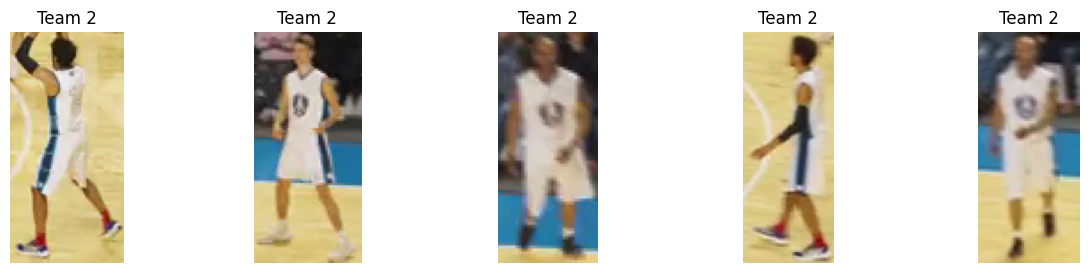

In [ ]:
import matplotlib.pyplot as plt

# Define the cluster labels
cluster_labels = ["Team 1", "Referee", "Team 2"]

# Group crops by cluster
crops_by_cluster = {i: [] for i in range(3)}
for crop, cluster_id in zip(crops, cluster_assignments):
    crops_by_cluster[cluster_id].append(crop)

# Display up to 5 samples from each cluster
SAMPLES_TO_SHOW = 5
for cluster_id, samples in crops_by_cluster.items():
    cluster_name = cluster_labels[cluster_id]
    num_samples = len(samples)

    print(f"Cluster: {cluster_name} (Showing {min(SAMPLES_TO_SHOW, num_samples)} of {num_samples} samples)")

    # Create a figure for the cluster
    plt.figure(figsize=(SAMPLES_TO_SHOW * 3, 3))  # Adjust figure size
    for i, crop in enumerate(samples[:SAMPLES_TO_SHOW]):  # Only take up to 5 samples
        plt.subplot(1, SAMPLES_TO_SHOW, i + 1)
        plt.imshow(sv.cv2_to_pillow(crop))
        plt.title(f"{cluster_name}")
        plt.axis("off")

    # Show the cluster
    plt.show()



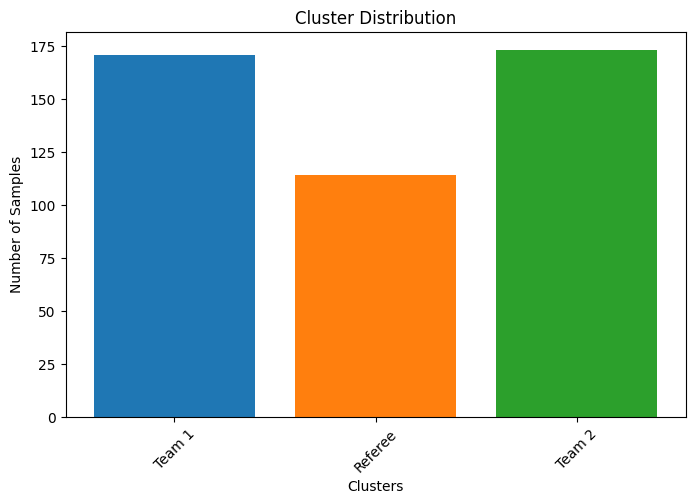

In [ ]:
import matplotlib.pyplot as plt

# Cluster distribution
cluster_counts = {cluster_labels[i]: len(samples) for i, samples in crops_by_cluster.items()}

# Create a bar chart for cluster distribution
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Cluster Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Clusters")
plt.xticks(rotation=45)
plt.show()


## Annotate first 10 seconds of video (Recomended)

If the google colab freezes you may need to refresh the page.
The result will be store in the files folder as 010101_result.mp4.

In [ ]:
SOURCE_VIDEO_PATH = "010101.mp4" # Path to the input video
TARGET_VIDEO_PATH = "010101_result.mp4" # Path to save the processed video

# Class IDs for objects we want to detect
BALL_ID = 0  # class ID 0 corresponds to "ball"
PERSON_ID = 2  # class ID 2 corresponds to "person"
RIM_ID = 3  # class ID 3 corresponds to "rim"
SHOOT_ID = 4  # class ID 4 corresponds to "shooting"

# Annotators for visualization
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), # Colors for different teams
    thickness=2
)
rim_annotator = sv.EllipseAnnotator(
    color=sv.Color.from_hex('#32CD32'),  # Green color for rims
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), # Label background colors
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'), # Yellow color for ball annotations
    base=25,
    height=21,
    outline_thickness=1
)
shoot_annotator = sv.BoxAnnotator(
    color=sv.Color.from_hex('#FF0000'),  # Red color for shooting players
    thickness=3
)

tracker = sv.ByteTrack() # Initialize the tracker for object tracking
tracker.reset() # Reset the tracker to start fresh

# Get video info
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Calculate the maximum frame to process (first 10 seconds)
max_frames = int(video_info.fps * 10)

# Initialize video sink and frame generator
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame_index, frame in enumerate(tqdm(frame_generator, total=min(max_frames, video_info.total_frames))):
        if frame_index >= max_frames:
            break  # Stop processing after 10 seconds

        # Model inference
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # Filter detections for ball, person, rim, and shooting
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        rim_detections = detections[detections.class_id == RIM_ID]
        shoot_detections = detections[detections.class_id == SHOOT_ID]

        person_detections = detections[(detections.class_id == PERSON_ID)]

        # Apply NMS and update tracker for person detections
        person_detections = person_detections.with_nms(threshold=0.5, class_agnostic=True)
        person_detections = tracker.update_with_detections(detections=person_detections)

        # Extract crops for persons
        person_crops = [sv.crop_image(frame, xyxy) for xyxy in person_detections.xyxy]

        # Predict teams for persons
        team_assignments = team_classifier.predict(person_crops)

        # Assign the predicted class IDs (Team 1, Team 2, Referee) back to person detections
        person_detections.class_id = team_assignments

        # Create labels for tracked persons
        labels = [
            f"#{tracker_id}"
            for tracker_id in person_detections.tracker_id
        ]

        # Annotate all elements in a single operation
        annotated_frame = frame.copy()

        # Add annotations for tracked persons
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=person_detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=person_detections,
            labels=labels
        )
        # Add annotations for rims
        annotated_frame = rim_annotator.annotate(
            scene=annotated_frame,
            detections=rim_detections
        )
        # Add annotations for ball
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections
        )

        # Annotate shooting player with a red box
        annotated_frame = shoot_annotator.annotate(
            scene=annotated_frame,
            detections=shoot_detections
        )

        # Write the final annotated frame to the video
        video_sink.write_frame(annotated_frame)


  0%|          | 0/250 [00:00<?, ?it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  5.79it/s]
  0%|          | 1/250 [00:06<27:20,  6.59s/it]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  6.19it/s]
  1%|          | 2/250 [00:06<11:47,  2.85s/it]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  7.35it/s]
  1%|          | 3/250 [00:07<06:47,  1.65s/it]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  7.89it/s]
  2%|▏         | 4/250 [00:07<04:24,  1.08s/it]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  7.85it/s]
  2%|▏         | 5/250 [00:07<03:09,  1.29it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  8.02it/s]
  2%|▏         | 6/250 [00:07<02:20,  1.74it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  7.06it/s]
  3%|▎         | 7/250 [00:07<01:53,  2.14it/s]
Extracting features: 0it [00:00, ?it

## Annotate entire video

If the google colab freezes you may need to refresh the page. The result will be store in the files folder as 010101_result.mp4.

In [ ]:
import supervision as sv
import numpy as np
from tqdm import tqdm

SOURCE_VIDEO_PATH = "010101.mp4" # path to the input video
TARGET_VIDEO_PATH = "010101_result.mp4" # path to save the processed video

# Class IDs for objects we want to detect
BALL_ID = 0  # class ID 0 corresponds to "ball"
PERSON_ID = 2  # class ID 2 corresponds to "person"
RIM_ID = 3  # class ID 3 corresponds to "rim"
SHOOT_ID = 4  # class ID 4 corresponds to "shooting"

# Annotators for visualization
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), # Colors for different teams
    thickness=2
)
rim_annotator = sv.EllipseAnnotator(
    color=sv.Color.from_hex('#32CD32'),  # Green color for rims
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), # Label background colors
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'), # Yellow color for ball annotations
    base=25,
    height=21,
    outline_thickness=1
)
shoot_annotator = sv.BoxAnnotator(
    color=sv.Color.from_hex('#FF0000'),  # Red color for shooting players
    thickness=3
)

tracker = sv.ByteTrack() # Initialize the tracker for object tracking
tracker.reset() # Reset the tracker to start fresh

# Get video info
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Initialize video sink and frame generator
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame_index, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):
        # Model inference
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # Filter detections for ball, person, rim, and shooting
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        rim_detections = detections[detections.class_id == RIM_ID]
        shoot_detections = detections[detections.class_id == SHOOT_ID]

        person_detections = detections[(detections.class_id == PERSON_ID)]

        # Apply NMS and update tracker for person detections
        person_detections = person_detections.with_nms(threshold=0.5, class_agnostic=True)
        person_detections = tracker.update_with_detections(detections=person_detections)

        # Extract crops for persons
        person_crops = [sv.crop_image(frame, xyxy) for xyxy in person_detections.xyxy]

        # Predict teams for persons
        team_assignments = team_classifier.predict(person_crops)

        # Assign the predicted class IDs (Team 1, Team 2, Referee) back to person detections
        person_detections.class_id = team_assignments

        # Create labels for tracked persons
        labels = [
            f"#{tracker_id}"
            for tracker_id in person_detections.tracker_id
        ]

        # Annotate all elements in a single operation
        annotated_frame = frame.copy()

        # Add annotations for tracked persons
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=person_detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=person_detections,
            labels=labels
        )
        # Add annotations for rims
        annotated_frame = rim_annotator.annotate(
            scene=annotated_frame,
            detections=rim_detections
        )
        # Add annotations for ball
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections
        )

        # Annotate shooting player with a red box
        annotated_frame = shoot_annotator.annotate(
            scene=annotated_frame,
            detections=shoot_detections
        )

        # Write the final annotated frame to the video
        video_sink.write_frame(annotated_frame)


  0%|          | 0/1466 [00:00<?, ?it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  5.76it/s]
  0%|          | 1/1466 [00:05<2:07:19,  5.21s/it]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  6.63it/s]
  0%|          | 2/1466 [00:05<55:20,  2.27s/it]  
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  8.11it/s]
  0%|          | 3/1466 [00:05<32:01,  1.31s/it]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  8.16it/s]
  0%|          | 4/1466 [00:05<21:00,  1.16it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  8.71it/s]
  0%|          | 5/1466 [00:05<14:50,  1.64it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  7.98it/s]
  0%|          | 6/1466 [00:06<11:14,  2.16it/s]
Extracting features: 0it [00:00, ?it/s]
Extracting features: 1it [00:00,  8.42it/s]
  0%|          | 7/1466 [00:06<08:55,  2.72it/s]
Extracting features: 0it